In [1]:
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
#from sklearn.pipeline import make_pipeline
#from pandas_profiling import ProfileReport
from sklearn.model_selection import KFold, ShuffleSplit, GridSearchCV

In [2]:
df = pd.read_csv('/Users/denisserbin/PycharmProjects/diploma_cost_research/russian_estate.csv')
df.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1


# Предварительный анализ данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   time           object 
 3   geo_lat        float64
 4   geo_lon        float64
 5   region         int64  
 6   building_type  int64  
 7   level          int64  
 8   levels         int64  
 9   rooms          int64  
 10  area           float64
 11  kitchen_area   float64
 12  object_type    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 543.2+ MB


In [4]:
df.describe()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
count,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06
mean,4.422029e+06,5.403826e+01,5.324433e+01,4.307141e+03,1.948966e+00,6.214530e+00,1.139892e+01,1.726173e+00,5.391825e+01,1.062840e+01,3.945399e+00
std,2.150752e+07,4.622758e+00,2.074763e+01,3.308050e+03,1.038537e+00,4.957419e+00,6.535734e+00,1.082133e+00,3.335293e+01,9.792380e+00,4.558357e+00
min,-2.144967e+09,4.145906e+01,1.989020e+01,3.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-2.000000e+00,7.000000e-02,1.000000e-02,1.000000e+00
25%,1.950000e+06,5.337768e+01,3.777790e+01,2.661000e+03,1.000000e+00,2.000000e+00,5.000000e+00,1.000000e+00,3.800000e+01,7.000000e+00,1.000000e+00
50%,2.990000e+06,5.517139e+01,4.306774e+01,2.922000e+03,2.000000e+00,5.000000e+00,1.000000e+01,2.000000e+00,4.802000e+01,9.700000e+00,1.000000e+00
75%,4.802000e+06,5.622613e+01,6.564895e+01,6.171000e+03,3.000000e+00,9.000000e+00,1.600000e+01,2.000000e+00,6.313000e+01,1.270000e+01,1.100000e+01
max,2.147484e+09,7.198040e+01,1.625361e+02,6.188800e+04,5.000000e+00,3.900000e+01,3.900000e+01,1.000000e+01,7.856000e+03,9.999000e+03,1.100000e+01


In [5]:
df.isnull().sum()

price            0
date             0
time             0
geo_lat          0
geo_lon          0
region           0
building_type    0
level            0
levels           0
rooms            0
area             0
kitchen_area     0
object_type      0
dtype: int64

In [6]:
df[df['price'] <= 0]

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
43821,-1633967296,2018-09-14,10:48:27,57.983337,56.216044,5520,1,13,22,1,38.92,17.26,11
43822,-1633967296,2018-09-14,10:48:27,57.983337,56.216044,5520,1,14,22,1,38.92,17.26,11
179212,0,2018-10-01,08:59:36,53.327778,83.668570,6817,3,5,10,3,104.00,15.00,1
199895,-429242296,2018-10-04,09:21:35,55.038734,82.985600,9654,2,5,25,2,57.27,9.31,11
208483,-1744967296,2018-10-06,05:06:46,54.991330,82.882575,9654,3,4,5,2,45.00,6.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382188,-2041757296,2021-04-23,07:00:09,57.636265,39.973962,2604,3,2,4,1,41.08,9.31,11
5382595,-1794967296,2021-04-23,07:37:00,56.115619,38.416266,81,1,4,5,2,56.00,9.00,1
5398253,-1494967296,2021-04-26,05:04:58,45.111303,36.881901,2843,3,3,3,1,45.00,17.00,11
5419426,-2094967296,2021-04-27,09:05:31,58.223183,68.305352,3991,3,14,19,1,30.00,8.00,1


In [7]:
df = df[df['price'] > 0]
df.shape

(5476618, 13)

In [8]:
df_real = df.copy()

In [9]:
df_real['building_type'] = df_real['building_type'].replace([0, 1, 2, 3, 4, 5],
                                                            ['Other', 'Panel', 'Monolithic', 'Brick', 'Blocky',
                                                             'Wooden'])
df_real['object_type'] = df_real['object_type'].replace([1, 11], ['Secondary Real Estate', 'New Building'])

In [10]:
df_real.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,Panel,8,10,3,82.6,10.8,Secondary Real Estate
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,Brick,5,24,2,69.1,12.0,Secondary Real Estate
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,Panel,5,9,3,66.0,10.0,Secondary Real Estate
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,Blocky,12,16,2,38.0,5.0,New Building
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,Brick,13,14,2,60.0,10.0,Secondary Real Estate


In [11]:
df_real['date'] = pd.to_datetime(df_real['date'])
df_real['time'] = pd.to_datetime(df_real['time'])

In [12]:
df_real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5476618 entries, 0 to 5477005
Data columns (total 13 columns):
 #   Column         Dtype         
---  ------         -----         
 0   price          int64         
 1   date           datetime64[ns]
 2   time           datetime64[ns]
 3   geo_lat        float64       
 4   geo_lon        float64       
 5   region         int64         
 6   building_type  object        
 7   level          int64         
 8   levels         int64         
 9   rooms          int64         
 10  area           float64       
 11  kitchen_area   float64       
 12  object_type    object        
dtypes: datetime64[ns](2), float64(4), int64(5), object(2)
memory usage: 585.0+ MB


In [13]:
df_real['price'] = df_real['price'] / 1000000

In [14]:
df_real.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6.05,2018-02-19,2023-05-23 20:00:21,59.805808,30.376141,2661,Panel,8,10,3,82.6,10.8,Secondary Real Estate
1,8.65,2018-02-27,2023-05-23 12:04:54,55.683807,37.297405,81,Brick,5,24,2,69.1,12.0,Secondary Real Estate
2,4.00,2018-02-28,2023-05-23 15:44:00,56.295250,44.061637,2871,Panel,5,9,3,66.0,10.0,Secondary Real Estate
3,1.85,2018-03-01,2023-05-23 11:24:52,44.996132,39.074783,2843,Blocky,12,16,2,38.0,5.0,New Building
4,5.45,2018-03-01,2023-05-23 17:42:43,55.918767,37.984642,81,Brick,13,14,2,60.0,10.0,Secondary Real Estate


In [15]:
df_real[df_real['price'] > 1000]

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
900,1451.892000,2018-09-08,2023-05-23 01:54:34,55.013994,83.003319,9654,Panel,9,10,3,59.02,45.50,New Building
908,1003.425000,2018-09-08,2023-05-23 01:54:43,55.013994,83.003319,9654,Panel,9,10,1,39.35,4.39,New Building
5215,1003.425000,2018-09-09,2023-05-23 04:00:07,55.013994,83.003319,9654,Panel,9,10,1,39.35,4.39,New Building
5224,1451.892000,2018-09-09,2023-05-23 04:00:16,55.013994,83.003319,9654,Panel,9,10,3,59.02,45.50,New Building
9890,1451.892000,2018-09-10,2023-05-23 04:35:26,55.013994,83.003319,9654,Panel,9,10,3,59.02,45.50,New Building
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5131302,1500.000000,2021-03-11,2023-05-23 09:49:14,56.121198,47.180265,3019,Brick,8,9,1,31.00,5.60,Secondary Real Estate
5217895,1096.745000,2021-03-25,2023-05-23 14:25:21,55.758177,37.592653,3,Brick,2,7,5,420.00,52.00,Secondary Real Estate
5232384,1555.032704,2021-03-29,2023-05-23 12:22:05,56.319472,44.054239,2871,Brick,2,9,3,61.50,7.30,Secondary Real Estate
5389809,1600.000000,2021-04-24,2023-05-23 09:29:19,44.839809,38.494939,2843,Brick,3,3,2,53.00,13.00,Secondary Real Estate


In [16]:
Qp11 = df_real['price'].quantile(0.25)
Qp31 = df_real['price'].quantile(0.75)
IQR1 = Qp31 - Qp11
IQR1
df_real['price'].median

<bound method NDFrame._add_numeric_operations.<locals>.median of 0           6.05000
1           8.65000
2           4.00000
3           1.85000
4           5.45000
             ...   
5477001    19.73976
5477002    12.50316
5477003     8.80000
5477004    11.83191
5477005    13.31620
Name: price, Length: 5476618, dtype: float64>

In [17]:
df_real[df_real['price'] > (Qp31 + (1.5 * IQR1))]

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
29,11.50000,2018-04-03,2023-05-23 17:40:53,55.798921,37.738090,3,Panel,14,16,3,64.9,8.0,Secondary Real Estate
34,10.20000,2018-04-07,2023-05-23 15:23:20,55.655307,37.614605,3,Monolithic,7,14,2,52.8,10.0,Secondary Real Estate
44,11.50000,2018-04-18,2023-05-23 21:52:41,55.701330,37.507412,3,Panel,14,17,1,42.0,12.0,Secondary Real Estate
56,20.90000,2018-05-01,2023-05-23 13:33:09,55.730785,37.631424,3,Brick,6,10,3,80.0,8.2,Secondary Real Estate
59,12.00000,2018-05-12,2023-05-23 21:08:19,55.627136,37.591736,3,Panel,4,9,3,64.9,7.0,Secondary Real Estate
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5476999,12.85000,2021-05-01,2023-05-23 20:13:47,55.701280,37.642654,3,Monolithic,12,24,1,41.0,9.0,Secondary Real Estate
5477001,19.73976,2021-05-01,2023-05-23 20:13:58,55.804736,37.750898,3,Panel,8,17,4,93.2,13.8,New Building
5477002,12.50316,2021-05-01,2023-05-23 20:14:01,55.841415,37.489624,3,Monolithic,17,32,2,45.9,6.6,New Building
5477004,11.83191,2021-05-01,2023-05-23 20:14:12,55.804736,37.750898,3,Panel,8,33,2,52.1,18.9,New Building


In [18]:
df_outlier = df_real[df_real['price'] > (Qp31 + (1.5 * IQR1))]
df_outlier['price'].mean()

19.274886410994544

In [19]:
df_outlier.groupby(['building_type'])['building_type'].agg('count')

building_type
Blocky          6777
Brick         114653
Monolithic    211144
Other          26738
Panel          72759
Wooden           380
Name: building_type, dtype: int64

In [20]:
df_real = df_real[df_real['price'] < 19]
df_real.shape

(5388250, 13)

In [21]:
df_real[df_real['price'] < 0.5]

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
1514,0.3000,2018-09-08,2023-05-23 04:59:20,52.561070,85.234409,6817,Wooden,1,1,1,26.0,7.0,Secondary Real Estate
1596,0.4800,2018-09-08,2023-05-23 06:43:33,51.523402,81.224751,6817,Panel,1,5,1,31.0,6.0,Secondary Real Estate
1916,0.2500,2018-09-08,2023-05-23 09:08:31,48.046666,40.125644,3230,Panel,1,5,1,21.0,6.0,Secondary Real Estate
2234,0.4550,2018-09-08,2023-05-23 10:21:48,58.270120,59.706687,6171,Brick,1,2,2,49.9,3.0,Secondary Real Estate
2241,0.4500,2018-09-08,2023-05-23 10:23:33,45.508422,38.083928,2843,Panel,2,2,1,45.0,12.0,Secondary Real Estate
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5474635,0.3200,2021-05-01,2023-05-23 16:18:49,55.784830,42.628058,2871,Brick,2,2,2,45.0,6.0,Secondary Real Estate
5476102,0.0063,2021-05-01,2023-05-23 18:35:48,55.926270,37.723278,81,Monolithic,15,17,1,33.0,9.4,Secondary Real Estate
5476156,0.0110,2021-05-01,2023-05-23 18:42:38,48.747428,44.509038,4695,Monolithic,18,18,1,38.0,11.0,Secondary Real Estate
5476168,0.3500,2021-05-01,2023-05-23 18:44:43,63.845328,57.299018,4417,Panel,2,5,3,59.0,6.0,Secondary Real Estate


In [22]:
df_real = df_real[df_real['price'] >= 0.5]

In [23]:
df_real.shape

(5370655, 13)

In [24]:
def binning_price(x):
    if x > 0 and x <= 5:
        p = 'Low'
    elif x > 5 and x < 10:
        p = 'Medium'
    else:
        p = 'High'
    return p

In [25]:
df_real['Price Binning'] = df_real['price'].apply(binning_price)

In [26]:
df_real.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,Price Binning
0,6.05,2018-02-19,2023-05-23 20:00:21,59.805808,30.376141,2661,Panel,8,10,3,82.6,10.8,Secondary Real Estate,Medium
1,8.65,2018-02-27,2023-05-23 12:04:54,55.683807,37.297405,81,Brick,5,24,2,69.1,12.0,Secondary Real Estate,Medium
2,4.00,2018-02-28,2023-05-23 15:44:00,56.295250,44.061637,2871,Panel,5,9,3,66.0,10.0,Secondary Real Estate,Low
3,1.85,2018-03-01,2023-05-23 11:24:52,44.996132,39.074783,2843,Blocky,12,16,2,38.0,5.0,New Building,Low
4,5.45,2018-03-01,2023-05-23 17:42:43,55.918767,37.984642,81,Brick,13,14,2,60.0,10.0,Secondary Real Estate,Medium


In [27]:

import folium
from folium import plugins
from shapely.geometry import Point, Polygon
from folium.plugins import FastMarkerCluster

In [28]:
df_real.groupby(['building_type'])['price'].agg(['mean', 'max', 'min'])

,mean,max,min
building_type,,,
Blocky,3.388761,18.999000,0.5
Brick,3.585744,18.999999,0.5
Monolithic,5.545933,18.999999,0.5
Other,4.439412,18.999000,0.5
Panel,3.159024,18.999999,0.5
Wooden,1.948708,18.999000,0.5


In [29]:
df_real.groupby(['object_type'])['price'].agg(['mean', 'max', 'min'])

,mean,max,min
object_type,,,
New Building,4.098699,18.999999,0.5
Secondary Real Estate,3.762812,18.999999,0.5


In [30]:
df_real.groupby(['building_type', 'Price Binning'])['Price Binning'].agg('count')

building_type  Price Binning
Blocky         High                4586
               Low               145867
               Medium             22174
Brick          High               69582
               Low              1519117
               Medium            268816
Monolithic     High              128047
               Low               617694
               Medium            332500
Other          High               15677
               Low               214092
               Medium             71264
Panel          High               50895
               Low              1668817
               Medium            227030
Wooden         High                 223
               Low                13656
               Medium               618
Name: Price Binning, dtype: int64

In [31]:
df_real.groupby(['object_type', 'Price Binning'])['Price Binning'].agg('count')

object_type            Price Binning
New Building           High              101761
                       Low              1163259
                       Medium            316221
Secondary Real Estate  High              167249
                       Low              3015984
                       Medium            606181
Name: Price Binning, dtype: int64

# Анализ данных

In [32]:
df_analys = df_real

### Распределение целевой фичи

In [33]:
df_analys

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,Price Binning
0,6.05000,2018-02-19,2023-05-23 20:00:21,59.805808,30.376141,2661,Panel,8,10,3,82.6,10.8,Secondary Real Estate,Medium
1,8.65000,2018-02-27,2023-05-23 12:04:54,55.683807,37.297405,81,Brick,5,24,2,69.1,12.0,Secondary Real Estate,Medium
2,4.00000,2018-02-28,2023-05-23 15:44:00,56.295250,44.061637,2871,Panel,5,9,3,66.0,10.0,Secondary Real Estate,Low
3,1.85000,2018-03-01,2023-05-23 11:24:52,44.996132,39.074783,2843,Blocky,12,16,2,38.0,5.0,New Building,Low
4,5.45000,2018-03-01,2023-05-23 17:42:43,55.918767,37.984642,81,Brick,13,14,2,60.0,10.0,Secondary Real Estate,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5477000,9.00000,2021-05-01,2023-05-23 20:13:48,44.051357,42.867573,2900,Brick,4,5,4,178.0,20.0,Secondary Real Estate,Medium
5477002,12.50316,2021-05-01,2023-05-23 20:14:01,55.841415,37.489624,3,Monolithic,17,32,2,45.9,6.6,New Building,High
5477003,8.80000,2021-05-01,2023-05-23 20:14:04,56.283909,44.075408,2871,Monolithic,4,17,3,86.5,11.8,Secondary Real Estate,Medium
5477004,11.83191,2021-05-01,2023-05-23 20:14:12,55.804736,37.750898,3,Panel,8,33,2,52.1,18.9,New Building,High


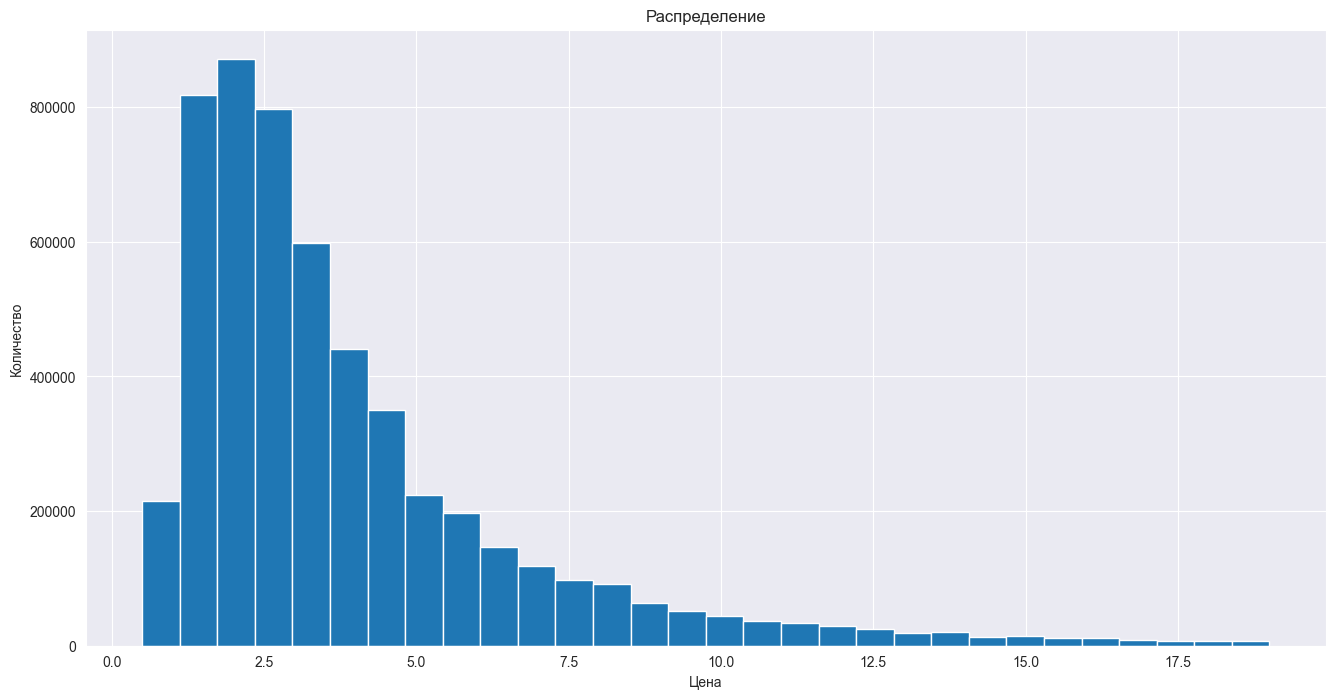

In [34]:
plt.figure(figsize=(16, 8))

df_analys['price'].hist(bins=30)
plt.ylabel('Количество')
plt.xlabel('Цена')

plt.title('Распределение')
plt.show()

### Регионы по продажи квартир

![](region_distrib.png)

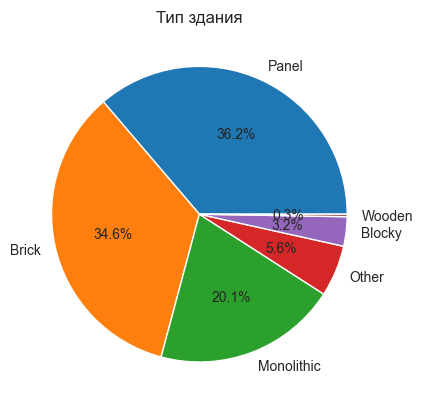

In [35]:
building_types = df_analys['building_type'].value_counts()
plt.pie(building_types.values, labels=building_types.index, autopct='%1.1f%%')
plt.title('Тип здания')
plt.show()

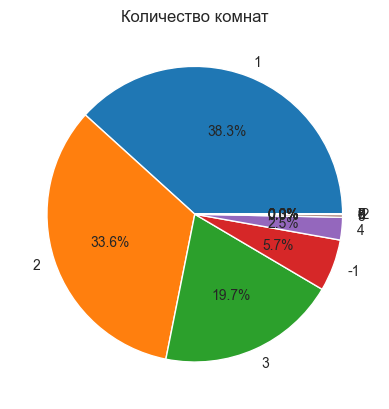

In [36]:
rooms = df_analys['rooms'].value_counts()
plt.pie(rooms.values, labels=rooms.index, autopct='%1.1f%%')
plt.title('Количество комнат')
plt.show()

In [37]:
df_analys

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,Price Binning
0,6.05000,2018-02-19,2023-05-23 20:00:21,59.805808,30.376141,2661,Panel,8,10,3,82.6,10.8,Secondary Real Estate,Medium
1,8.65000,2018-02-27,2023-05-23 12:04:54,55.683807,37.297405,81,Brick,5,24,2,69.1,12.0,Secondary Real Estate,Medium
2,4.00000,2018-02-28,2023-05-23 15:44:00,56.295250,44.061637,2871,Panel,5,9,3,66.0,10.0,Secondary Real Estate,Low
3,1.85000,2018-03-01,2023-05-23 11:24:52,44.996132,39.074783,2843,Blocky,12,16,2,38.0,5.0,New Building,Low
4,5.45000,2018-03-01,2023-05-23 17:42:43,55.918767,37.984642,81,Brick,13,14,2,60.0,10.0,Secondary Real Estate,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5477000,9.00000,2021-05-01,2023-05-23 20:13:48,44.051357,42.867573,2900,Brick,4,5,4,178.0,20.0,Secondary Real Estate,Medium
5477002,12.50316,2021-05-01,2023-05-23 20:14:01,55.841415,37.489624,3,Monolithic,17,32,2,45.9,6.6,New Building,High
5477003,8.80000,2021-05-01,2023-05-23 20:14:04,56.283909,44.075408,2871,Monolithic,4,17,3,86.5,11.8,Secondary Real Estate,Medium
5477004,11.83191,2021-05-01,2023-05-23 20:14:12,55.804736,37.750898,3,Panel,8,33,2,52.1,18.9,New Building,High


/var/folders/cs/rdytcwcn26gglq1gv10mb7x80000gn/T/ipykernel_17647/3487103093.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df_analys.corr()


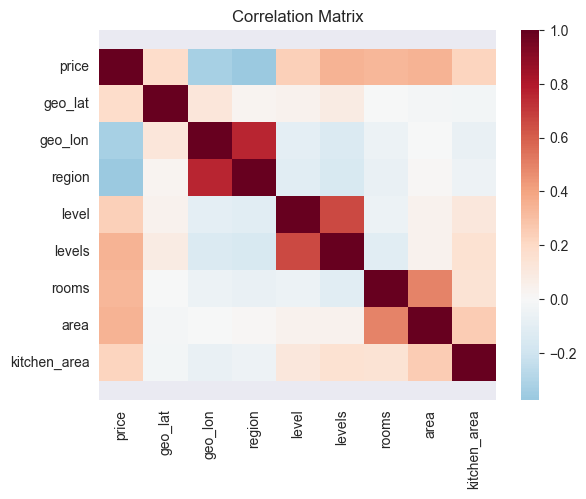

In [40]:
correlation = df_analys.corr()
ax = sns.heatmap(correlation, center=0, cmap='RdBu_r')
l, r = ax.get_ylim()
ax.set_ylim(l + 0.5, r - 0.5)
plt.yticks(rotation=0)
plt.title('Correlation Matrix')
plt.show()

### Временные ряды

In [66]:
import plotly
from plotly.offline import iplot
import plotly.graph_objs as go

In [68]:
df_analys

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,Price Binning
0,6.05000,2018-02-19,2023-05-23 20:00:21,59.805808,30.376141,2661,Panel,8,10,3,82.6,10.8,Secondary Real Estate,Medium
1,8.65000,2018-02-27,2023-05-23 12:04:54,55.683807,37.297405,81,Brick,5,24,2,69.1,12.0,Secondary Real Estate,Medium
2,4.00000,2018-02-28,2023-05-23 15:44:00,56.295250,44.061637,2871,Panel,5,9,3,66.0,10.0,Secondary Real Estate,Low
3,1.85000,2018-03-01,2023-05-23 11:24:52,44.996132,39.074783,2843,Blocky,12,16,2,38.0,5.0,New Building,Low
4,5.45000,2018-03-01,2023-05-23 17:42:43,55.918767,37.984642,81,Brick,13,14,2,60.0,10.0,Secondary Real Estate,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5477000,9.00000,2021-05-01,2023-05-23 20:13:48,44.051357,42.867573,2900,Brick,4,5,4,178.0,20.0,Secondary Real Estate,Medium
5477002,12.50316,2021-05-01,2023-05-23 20:14:01,55.841415,37.489624,3,Monolithic,17,32,2,45.9,6.6,New Building,High
5477003,8.80000,2021-05-01,2023-05-23 20:14:04,56.283909,44.075408,2871,Monolithic,4,17,3,86.5,11.8,Secondary Real Estate,Medium
5477004,11.83191,2021-05-01,2023-05-23 20:14:12,55.804736,37.750898,3,Panel,8,33,2,52.1,18.9,New Building,High


In [75]:
df_analys['estate_id'] = df_analys.index
df_analys

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,Price Binning,estate_id
0,6.05000,2018-02-19,2023-05-23 20:00:21,59.805808,30.376141,2661,Panel,8,10,3,82.6,10.8,Secondary Real Estate,Medium,0
1,8.65000,2018-02-27,2023-05-23 12:04:54,55.683807,37.297405,81,Brick,5,24,2,69.1,12.0,Secondary Real Estate,Medium,1
2,4.00000,2018-02-28,2023-05-23 15:44:00,56.295250,44.061637,2871,Panel,5,9,3,66.0,10.0,Secondary Real Estate,Low,2
3,1.85000,2018-03-01,2023-05-23 11:24:52,44.996132,39.074783,2843,Blocky,12,16,2,38.0,5.0,New Building,Low,3
4,5.45000,2018-03-01,2023-05-23 17:42:43,55.918767,37.984642,81,Brick,13,14,2,60.0,10.0,Secondary Real Estate,Medium,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5477000,9.00000,2021-05-01,2023-05-23 20:13:48,44.051357,42.867573,2900,Brick,4,5,4,178.0,20.0,Secondary Real Estate,Medium,5477000
5477002,12.50316,2021-05-01,2023-05-23 20:14:01,55.841415,37.489624,3,Monolithic,17,32,2,45.9,6.6,New Building,High,5477002
5477003,8.80000,2021-05-01,2023-05-23 20:14:04,56.283909,44.075408,2871,Monolithic,4,17,3,86.5,11.8,Secondary Real Estate,Medium,5477003
5477004,11.83191,2021-05-01,2023-05-23 20:14:12,55.804736,37.750898,3,Panel,8,33,2,52.1,18.9,New Building,High,5477004


In [77]:
df_analys['date'] = pd.to_datetime(df_analys['date'])
df_analys_filtereed = df_analys.assign(year=df_analys['date'].map(lambda dates: dates.year))
df_analys_filtereed = df_analys_filtereed.assign(month=df_analys['date'].map(lambda dates: dates.month))
df_analys_filtereed = df_analys_filtereed.assign(
    day=df_analys['date'].map(lambda dates: dates.weekday()))

y_yrs = df_analys_filtereed.groupby('year')['estate_id'].count().values
x_yrs = df_analys_filtereed.groupby('year')['estate_id'].count().index.values

y_months = df_analys_filtereed.groupby(by=['year', 'month']).agg('count').groupby('month')[
    'estate_id'].mean().values

x_months = ['Янв', 'Февр', 'Март', 'Апр', 'Май', 'Июнь', 'Июль', 'Авг', 'Сент', 'Окт', 'Нояб', 'Дек']

y_days = df_analys_filtereed.groupby(['year', 'day']).agg('count').groupby('day')['estate_id'].mean().values

x_days = ['Пон', 'Втор', 'Сред', 'Четв', 'Пятн', 'Субб', 'Воскр']

trace1 = go.Bar(
    x=x_yrs,
    y=y_yrs
)
trace2 = go.Bar(
    x=x_months,
    y=y_months,
    xaxis='x2',
    yaxis='y2'
)
trace3 = go.Bar(
    x=x_days,
    y=y_days,
    xaxis='x3',
    yaxis='y3'
)

data = [trace1, trace2, trace3]
fig = plotly.tools.make_subplots(rows=3, cols=1, specs=[[{}], [{}], [{}]], vertical_spacing=0.25,
                                 subplot_titles=('Количество недвижимости в год',
                                                 'Среднее количество недвижимости в месяц',
                                                 'Среднее количество недвижимости в день'))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 3, 1)

fig['layout']['xaxis1'].update(title='Года')
fig['layout']['xaxis2'].update(title='Месяцы')
fig['layout']['xaxis3'].update(title='Дни')

fig['layout']['yaxis1'].update(title='количество')
fig['layout']['yaxis2'].update(title='среднее количество')
fig['layout']['yaxis3'].update(title='среднее количество')

fig['layout'].update(showlegend=False, height=800, width=800, title='недвижимость зв все время')
iplot(fig)

/Users/denisserbin/PycharmProjects/diploma_cost_research/venv/lib/python3.8/site-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# Енкодинг

In [41]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

df_encode = df_real.copy()
for col in df_encode.select_dtypes(include='O').columns:
    df_encode[col] = le.fit_transform(df_encode[col])

In [42]:
df_encode.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,Price Binning
0,6.05,2018-02-19,2023-05-23 20:00:21,59.805808,30.376141,2661,4,8,10,3,82.6,10.8,1,2
1,8.65,2018-02-27,2023-05-23 12:04:54,55.683807,37.297405,81,1,5,24,2,69.1,12.0,1,2
2,4.00,2018-02-28,2023-05-23 15:44:00,56.295250,44.061637,2871,4,5,9,3,66.0,10.0,1,1
3,1.85,2018-03-01,2023-05-23 11:24:52,44.996132,39.074783,2843,0,12,16,2,38.0,5.0,0,1
4,5.45,2018-03-01,2023-05-23 17:42:43,55.918767,37.984642,81,1,13,14,2,60.0,10.0,1,2


In [43]:
df_encode.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,Price Binning
0,6.05,2018-02-19,2023-05-23 20:00:21,59.805808,30.376141,2661,4,8,10,3,82.6,10.8,1,2
1,8.65,2018-02-27,2023-05-23 12:04:54,55.683807,37.297405,81,1,5,24,2,69.1,12.0,1,2
2,4.00,2018-02-28,2023-05-23 15:44:00,56.295250,44.061637,2871,4,5,9,3,66.0,10.0,1,1
3,1.85,2018-03-01,2023-05-23 11:24:52,44.996132,39.074783,2843,0,12,16,2,38.0,5.0,0,1
4,5.45,2018-03-01,2023-05-23 17:42:43,55.918767,37.984642,81,1,13,14,2,60.0,10.0,1,2


In [44]:
df_encode.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,Price Binning
0,6.05,2018-02-19,2023-05-23 20:00:21,59.805808,30.376141,2661,4,8,10,3,82.6,10.8,1,2
1,8.65,2018-02-27,2023-05-23 12:04:54,55.683807,37.297405,81,1,5,24,2,69.1,12.0,1,2
2,4.00,2018-02-28,2023-05-23 15:44:00,56.295250,44.061637,2871,4,5,9,3,66.0,10.0,1,1
3,1.85,2018-03-01,2023-05-23 11:24:52,44.996132,39.074783,2843,0,12,16,2,38.0,5.0,0,1
4,5.45,2018-03-01,2023-05-23 17:42:43,55.918767,37.984642,81,1,13,14,2,60.0,10.0,1,2


In [45]:
df_encode = df_encode.drop(['Price Binning'], axis=1)

In [46]:
df_encode['year'] = df_encode.apply(lambda row: row['date'].year, axis=1)
df_encode['month'] = df_encode.apply(lambda row: row['date'].month, axis=1)
df_encode['day'] = df_encode.apply(lambda row: row['date'].day, axis=1)
# df_encode = df_encode.drop(['date'], axis=1)
df_encode = df_encode.drop(['date', 'time'], axis=1)

df_encode

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,day
0,6.05000,59.805808,30.376141,2661,4,8,10,3,82.6,10.8,1,2018,2,19
1,8.65000,55.683807,37.297405,81,1,5,24,2,69.1,12.0,1,2018,2,27
2,4.00000,56.295250,44.061637,2871,4,5,9,3,66.0,10.0,1,2018,2,28
3,1.85000,44.996132,39.074783,2843,0,12,16,2,38.0,5.0,0,2018,3,1
4,5.45000,55.918767,37.984642,81,1,13,14,2,60.0,10.0,1,2018,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5477000,9.00000,44.051357,42.867573,2900,1,4,5,4,178.0,20.0,1,2021,5,1
5477002,12.50316,55.841415,37.489624,3,2,17,32,2,45.9,6.6,0,2021,5,1
5477003,8.80000,56.283909,44.075408,2871,2,4,17,3,86.5,11.8,1,2021,5,1
5477004,11.83191,55.804736,37.750898,3,4,8,33,2,52.1,18.9,0,2021,5,1


In [47]:
df_encode.describe()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,day
count,5.370655e+06,5.370655e+06,5.370655e+06,5.370655e+06,5.370655e+06,5.370655e+06,5.370655e+06,5.370655e+06,5.370655e+06,5.370655e+06,5.370655e+06,5.370655e+06,5.370655e+06,5.370655e+06
mean,3.861704e+00,5.399418e+01,5.349408e+01,4.355334e+03,2.378955e+00,6.189537e+00,1.137180e+01,1.703210e+00,5.278128e+01,1.046279e+01,7.055776e-01,2.019372e+03,6.628343e+00,1.617948e+01
std,2.911250e+00,4.624327e+00,2.078076e+01,3.303812e+03,1.364215e+00,4.926545e+00,6.491183e+00,1.065667e+00,3.011260e+01,9.174507e+00,4.557827e-01,8.706952e-01,3.540280e+00,9.297457e+00
min,5.000000e-01,4.145906e+01,1.989020e+01,3.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-2.000000e+00,7.000000e-02,1.000000e-02,0.000000e+00,2.018000e+03,1.000000e+00,1.000000e+00
25%,1.948000e+00,5.335745e+01,3.784881e+01,2.661000e+03,1.000000e+00,2.000000e+00,5.000000e+00,1.000000e+00,3.800000e+01,7.000000e+00,0.000000e+00,2.019000e+03,3.000000e+00,8.000000e+00
50%,2.950000e+00,5.514087e+01,4.381391e+01,2.922000e+03,2.000000e+00,5.000000e+00,1.000000e+01,2.000000e+00,4.800000e+01,9.500000e+00,1.000000e+00,2.019000e+03,7.000000e+00,1.700000e+01
75%,4.700000e+00,5.618633e+01,7.343549e+01,6.171000e+03,4.000000e+00,9.000000e+00,1.600000e+01,2.000000e+00,6.280000e+01,1.240000e+01,1.000000e+00,2.020000e+03,1.000000e+01,2.400000e+01
max,1.900000e+01,7.198040e+01,1.625361e+02,6.188800e+04,5.000000e+00,3.900000e+01,3.900000e+01,9.000000e+00,7.856000e+03,9.999000e+03,1.000000e+00,2.021000e+03,1.200000e+01,3.100000e+01


In [48]:
for column in df_encode.columns:
    print(f"{column}: {df_encode[column].mean()}")

price: 3.861704259472452
geo_lat: 53.99417622805179
geo_lon: 53.494079516877704
region: 4355.334007490706
building_type: 2.37895545329201
level: 6.189537216596486
levels: 11.371798225728519
rooms: 1.7032101298631173
area: 52.781284387099916
kitchen_area: 10.462786904018218
object_type: 0.7055776250755261
year: 2019.3724843617772
month: 6.628343097815816
day: 16.179484811442926


# Обучение

In [49]:
X = df_encode.drop(['price'], axis=1).values
y = df_encode['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [50]:
# df_encode.drop(['price','Price Binning'],axis=1)

In [51]:
X

array([[5.98058084e+01, 3.03761410e+01, 2.66100000e+03, ...,
        2.01800000e+03, 2.00000000e+00, 1.90000000e+01],
       [5.56838070e+01, 3.72974050e+01, 8.10000000e+01, ...,
        2.01800000e+03, 2.00000000e+00, 2.70000000e+01],
       [5.62952500e+01, 4.40616370e+01, 2.87100000e+03, ...,
        2.01800000e+03, 2.00000000e+00, 2.80000000e+01],
       ...,
       [5.62839090e+01, 4.40754080e+01, 2.87100000e+03, ...,
        2.02100000e+03, 5.00000000e+00, 1.00000000e+00],
       [5.58047361e+01, 3.77508978e+01, 3.00000000e+00, ...,
        2.02100000e+03, 5.00000000e+00, 1.00000000e+00],
       [5.58602396e+01, 3.75403558e+01, 3.00000000e+00, ...,
        2.02100000e+03, 5.00000000e+00, 1.00000000e+00]])

In [52]:
X_train

array([[5.58362460e+01, 4.90975480e+01, 2.92200000e+03, ...,
        2.01900000e+03, 6.00000000e+00, 2.60000000e+01],
       [5.58053360e+01, 4.94479350e+01, 2.92200000e+03, ...,
        2.02000000e+03, 7.00000000e+00, 1.50000000e+01],
       [5.49449570e+01, 8.29627400e+01, 9.65400000e+03, ...,
        2.01900000e+03, 1.00000000e+00, 1.40000000e+01],
       ...,
       [5.31665238e+01, 4.84792582e+01, 3.10600000e+03, ...,
        2.01900000e+03, 7.00000000e+00, 2.20000000e+01],
       [5.62538994e+01, 9.56792976e+01, 3.87000000e+03, ...,
        2.01900000e+03, 4.00000000e+00, 1.00000000e+00],
       [5.68385216e+01, 6.06054911e+01, 6.17100000e+03, ...,
        2.02000000e+03, 1.00000000e+01, 1.90000000e+01]])

In [ ]:
from datetime import datetime

In [53]:
# Linear regression
line_start = datetime.now()
reg = LinearRegression()
reg.fit(X_train, y_train)
line_training_time = datetime.now()-line_start
line_training_time

LinearRegression()

In [54]:
X_train

array([[5.58362460e+01, 4.90975480e+01, 2.92200000e+03, ...,
        2.01900000e+03, 6.00000000e+00, 2.60000000e+01],
       [5.58053360e+01, 4.94479350e+01, 2.92200000e+03, ...,
        2.02000000e+03, 7.00000000e+00, 1.50000000e+01],
       [5.49449570e+01, 8.29627400e+01, 9.65400000e+03, ...,
        2.01900000e+03, 1.00000000e+00, 1.40000000e+01],
       ...,
       [5.31665238e+01, 4.84792582e+01, 3.10600000e+03, ...,
        2.01900000e+03, 7.00000000e+00, 2.20000000e+01],
       [5.62538994e+01, 9.56792976e+01, 3.87000000e+03, ...,
        2.01900000e+03, 4.00000000e+00, 1.00000000e+00],
       [5.68385216e+01, 6.06054911e+01, 6.17100000e+03, ...,
        2.02000000e+03, 1.00000000e+01, 1.90000000e+01]])

In [55]:
reg.fit(X_train, y_train)
# Ridge regression
ridge_start = datetime.now()

ridge = Ridge()
ridge.fit(X_train, y_train)

ridge_training_time = datetime.now()-line_start
ridge_training_time

Ridge()

In [56]:
# Random Forest Regression
rf_start = datetime.now()

rf = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=125, min_samples_leaf=125, max_samples=0.9,
                           max_leaf_nodes=150, max_features=5, max_depth=35)
rf.fit(X_train, y_train)

rf_training_time = datetime.now()-line_start
rf_training_time

RandomForestRegressor(max_depth=35, max_features=5, max_leaf_nodes=150,
                      max_samples=0.9, min_samples_leaf=125, n_estimators=125,
                      n_jobs=-1, random_state=42)

In [57]:
# XGB
xgb_start = datetime.now()

xgb = XGBRegressor(random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)

xgb_training_time = datetime.now()-line_start
xgb_training_time

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [58]:
def check_metrics(model):
    print('Training MAE', mean_absolute_error(y_train, model.predict(X_train)))
    print('Validation MAE', mean_absolute_error(y_test, model.predict(X_test)))
    print('Validation R^2', model.score(X_test, y_test))
    print()


models = [reg, ridge, rf, xgb]

for m in models:
    check_metrics(m)

Training MAE 1.4779374993437588
Validation MAE 1.4781227693365238
Validation R^2 0.437457038079458

Training MAE 1.4779374740364377
Validation MAE 1.4781227438276547
Validation R^2 0.43745703794311286

Training MAE 0.8323600069774681
Validation MAE 0.8321513800155403
Validation R^2 0.8080103142782245

Training MAE 0.5498743943915773
Validation MAE 0.5523472634488235
Validation R^2 0.8990880733372877



In [59]:
def plot_accuracy_models(models=[reg, ridge, rf, xgb]):
    model_name = pd.Series([str(model)[:10] for model in models], name='Модели').astype(str)

    mae_acc_test = pd.Series(
        [mean_absolute_error(y_train, model.predict(X_train)) for model in models],
        name='MAE тренировочная'
    )
    mae_output = pd.concat([model_name, mae_acc_test], axis=1)

    mae_test_acc_test = pd.Series(
        [mean_absolute_error(y_test, model.predict(X_test)) for model in models],
        name='MAE тестовая'
    )
    mae_test_output = pd.concat([model_name, mae_test_acc_test], axis=1)

    score_acc_test = pd.Series(
        [model.score(X_test, y_test) for model in models],
        name='Точность'
    )
    score_output = pd.concat([model_name, score_acc_test], axis=1)

    def subplot(output, y_name):
        plt.figure(figsize=(12, 7))
        sns.barplot(x='Модели', y=y_name, data=output)

    subplot(mae_output, 'MAE тренировочная')
    subplot(mae_test_output, 'MAE тестовая')
    subplot(score_output, 'Точность')

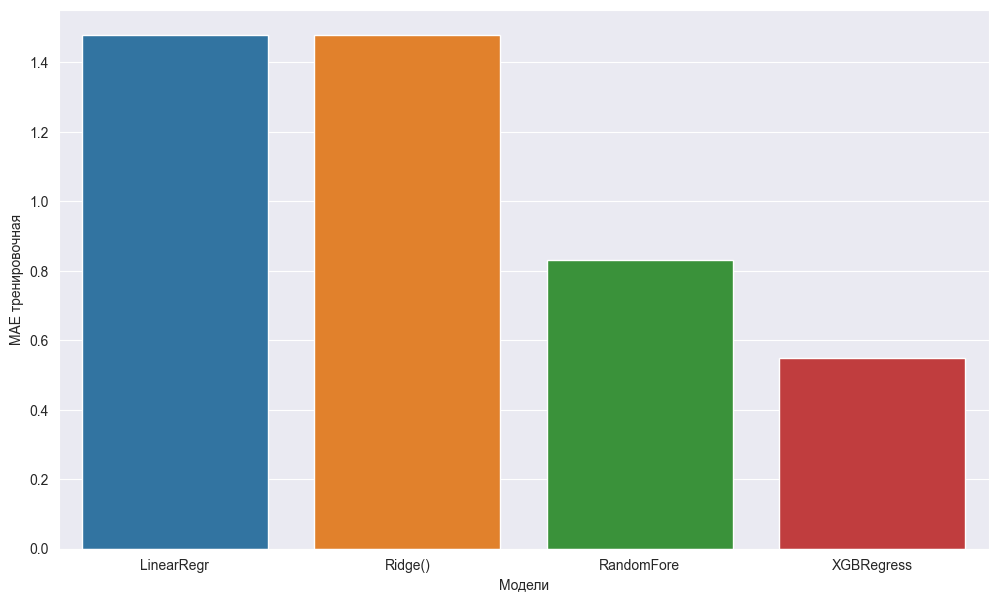

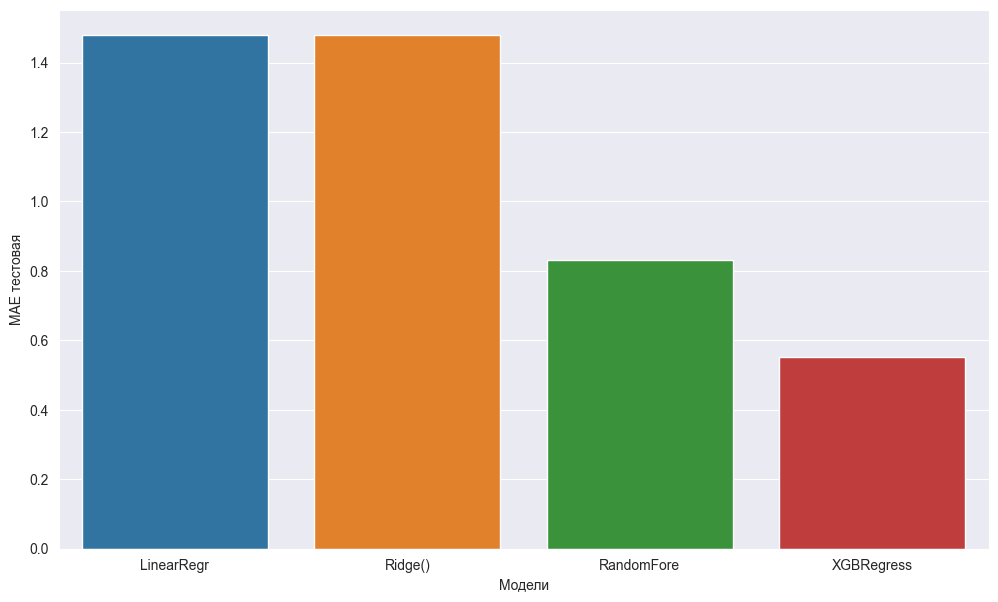

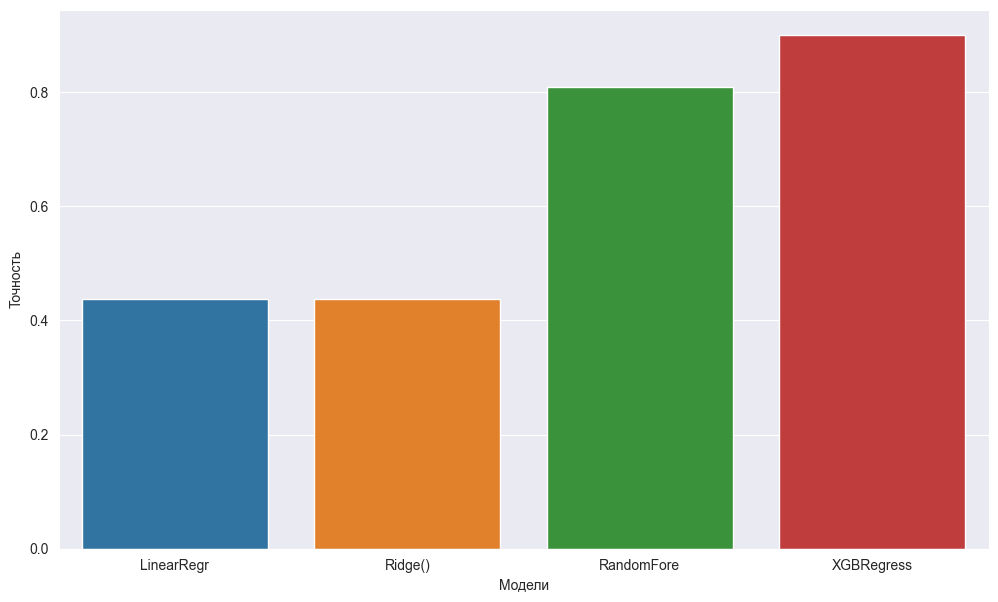

In [60]:
plot_accuracy_models()

### Распределение предсказанных данных


In [61]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    plt.figure(figsize=(18, 10))

    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Реальные значения')
    plt.title('Тренировочные данные')

    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Реальные значения')
    plt.title('Тестовые данные')

    plt.show()

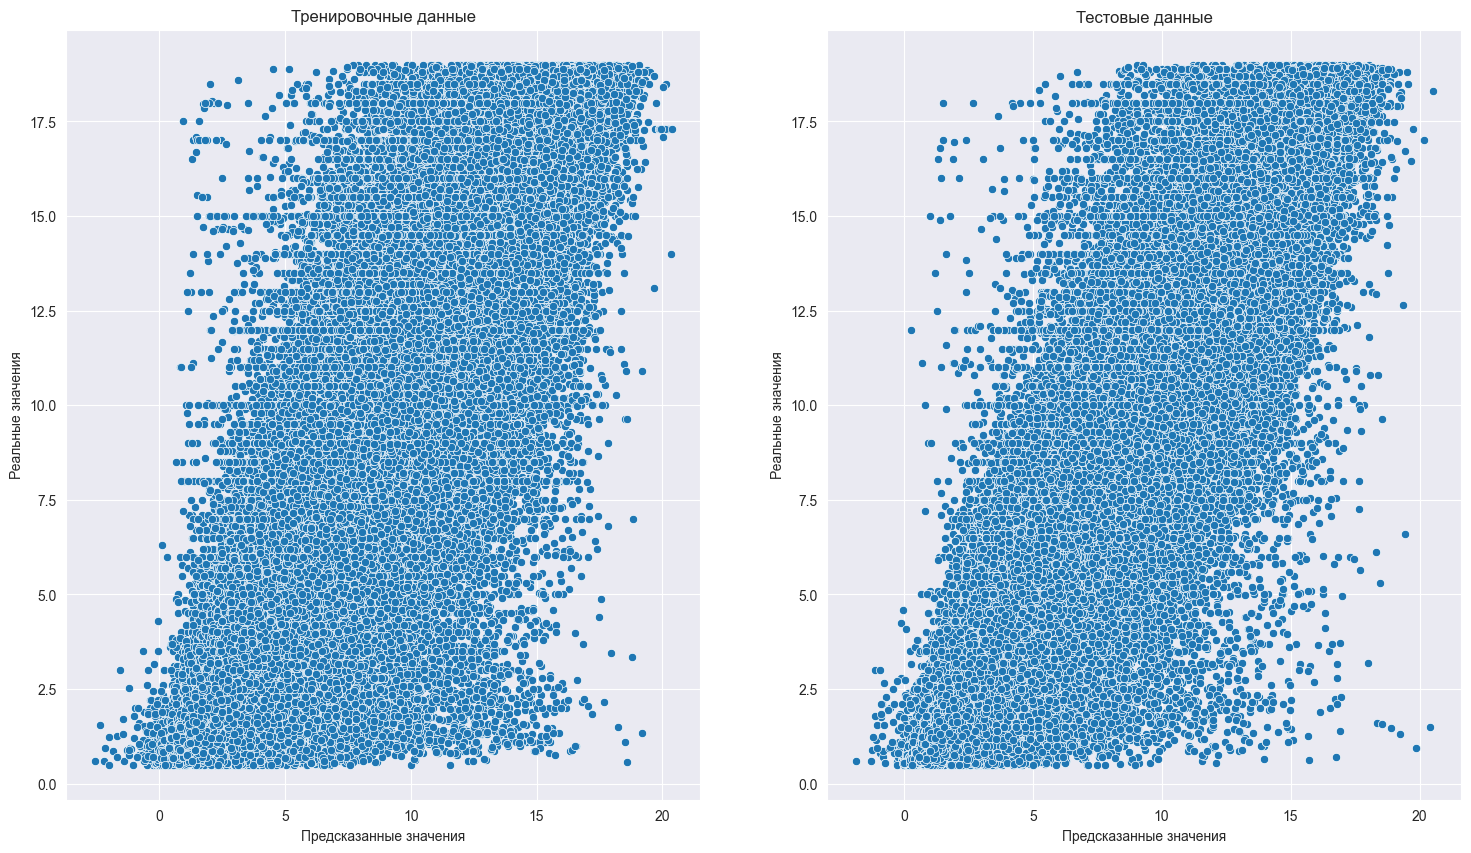

In [62]:
y_train_preds = xgb.predict(X_train)
y_valid_preds = xgb.predict(X_test)
evaluate_preds(y_train, y_train_preds, y_test, y_valid_preds)

### Важность признаков

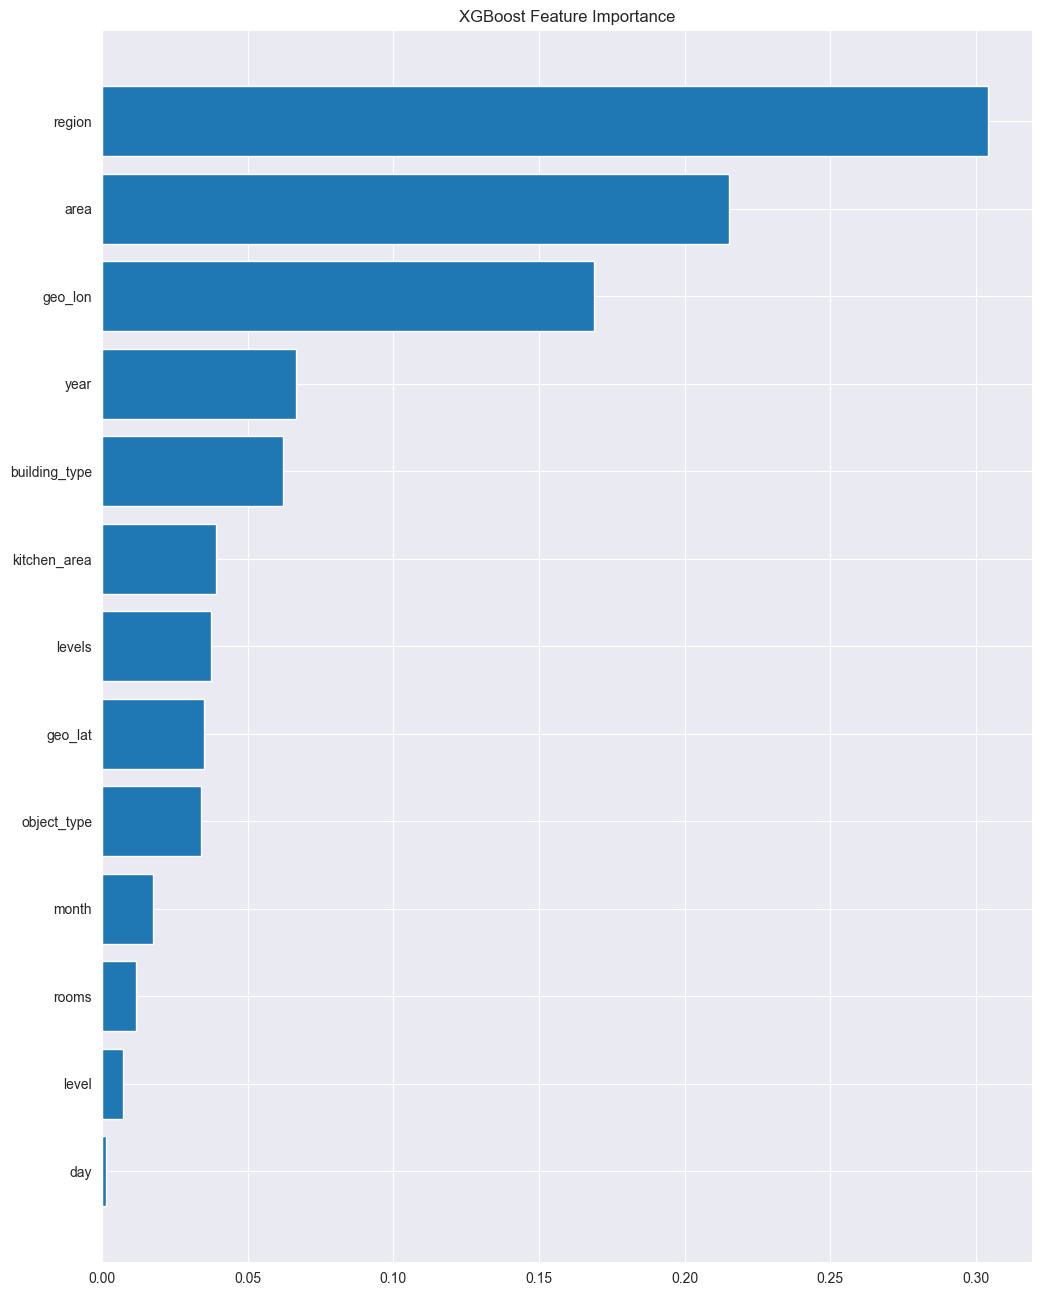

In [63]:
importance = pd.DataFrame({
    'features': df_encode.columns.drop(['price']),
    'importance': xgb.feature_importances_
})
importance.sort_values(by='importance', inplace=True)

plt.figure(figsize=(12, 16))
plt.barh(importance['features'], importance['importance'])
plt.title('XGBoost Feature Importance')
plt.show()

In [64]:
# xgb.save_model("xgb_model.json")